
Longueur totale des voies dans chaque catégorie :
residential : 1471.69 km
primary : 454.25 km
tertiary : 318.88 km
pedestrian : 311.44 km
secondary : 293.99 km
living_street : 106.45 km
unclassified : 79.34 km
primary_link : 14.99 km
('residential', 'pedestrian') : 13.85 km
('residential', 'living_street') : 12.33 km
('steps', 'pedestrian') : 9.88 km
('residential', 'unclassified') : 6.58 km
steps : 5.06 km
('residential', 'primary_link') : 3.21 km
('residential', 'steps') : 3.11 km
secondary_link : 2.71 km
('pedestrian', 'living_street') : 1.67 km
('secondary', 'primary') : 1.62 km
tertiary_link : 1.18 km
('unclassified', 'pedestrian') : 1.02 km
('primary_link', 'primary') : 0.75 km
busway : 0.62 km
('secondary_link', 'secondary') : 0.61 km
('residential', 'pedestrian', 'living_street') : 0.54 km
('living_street', 'tertiary') : 0.46 km
('residential', 'steps', 'pedestrian') : 0.33 km
('tertiary', 'primary') : 0.32 km
('primary', 'tertiary') : 0.32 km
('steps', 'living_street') : 0.2

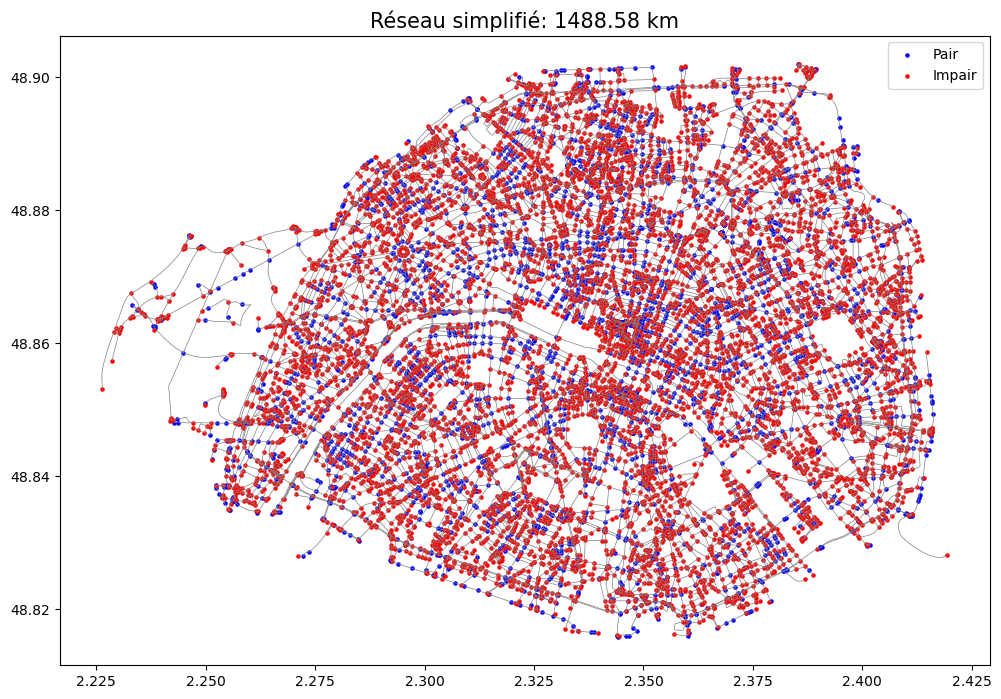

Le graphe est maintenant eulérien.
Distance totale du réseau augmenté: 1888.34 km
Nœud le plus proche de Notre-Dame: 2134912116
Distance totale du circuit eulérien (angle-minimizing) : 3774.59 km
Fichier GPX enregistré sous : eulerian_circuit_final_chinese.gpx


In [1]:
import osmnx as ox
import networkx as nx
from shapely.geometry import LineString, Point as ShapelyPoint
import matplotlib.pyplot as plt
import gpxpy
import gpxpy.gpx
import os

# On importe math, etc. pour calculs de bearing
import math

# ==========================================================
# FONCTIONS UTILES POUR CALCULER LES ANGLES / BEARINGS
# ==========================================================
def calculate_bearing(lat1, lon1, lat2, lon2):
    """
    Calcule l'angle de direction (bearing) entre deux points géographiques.
    Retourne l'angle en degrés [0..360].
    """
    # Conversion en radians
    rlat1, rlon1 = math.radians(lat1), math.radians(lon1)
    rlat2, rlon2 = math.radians(lat2), math.radians(lon2)
    
    # Formule standard
    y = math.sin(rlon2 - rlon1) * math.cos(rlat2)
    x = (math.cos(rlat1)*math.sin(rlat2) 
         - math.sin(rlat1)*math.cos(rlat2)*math.cos(rlon2 - rlon1))
    bearing = math.degrees(math.atan2(y, x))
    bearing = (bearing + 360) % 360
    return bearing

def angle_difference(bearing1, bearing2):
    """
    Calcule la différence d'angle entre deux directions (0..180).
    0 => même direction, 180 => demi-tour.
    """
    diff = abs(bearing1 - bearing2) % 360
    return min(diff, 360 - diff)

# =====================================================================
# VOTRE SCRIPT D'IMPORT, DE FILTRAGE ET DE CONSTRUCTION DU GRAPHE
# (JUSQU'A L'ETAPE 16, SANS MODIFICATION MAJEURE)
# =====================================================================

ville = "Paris, France"
custom_filter = ('["highway"~"residential|primary|secondary|tertiary|unclassified|pedestrian|tertiary_link|living_street|steps|secondary_link|primary_link|road|busway"]')
G = ox.graph_from_place(ville, network_type='walk', custom_filter=custom_filter)

G_init = G.copy()
for u, v, key, data in G_init.edges(keys=True, data=True):
    if 'length' not in data:
        print("il manque la longueur pour l'arête", u, v, key)    
    if 'geometry' not in data:
        x_u, y_u = G.nodes[u]['x'], G.nodes[u]['y']
        x_v, y_v = G.nodes[v]['x'], G.nodes[v]['y']
        data['geometry'] = LineString([(x_u, y_u), (x_v, y_v)])
        G.remove_edge(u, v, key=key)
        G.add_edge(u, v, key=key, **data)

edge_count = {}
edge_length = {}
for u, v, key, data in G.edges(keys=True, data=True):
    highway_type = tuple(data['highway']) if isinstance(data['highway'], list) else data['highway']
    edge_count[highway_type] = edge_count.get(highway_type, 0) + 1
    edge_length[highway_type] = edge_length.get(highway_type, 0) + data['length']

print("\nLongueur totale des voies dans chaque catégorie :")
for key, value in sorted(edge_length.items(), key=lambda x: x[1], reverse=True):
    print(f"{key} : {value/1000:.2f} km")

print(f"Type de G : {type(G)}")

# Étape 2 : Convertir en MultiGraph
G_multigraph = G.to_undirected()
G_multigraph = nx.MultiGraph(G_multigraph)

print(f"Type de G_multigraph : {type(G_multigraph)}")
print(f"Le graphe G_multigraph est dirigé ? {G_multigraph.is_directed()}")

# Étape 3 : Reprojeter (ici on copie simplement)
G_proj = G_multigraph.copy()

# Étape 3bis : Supprimer les segments sans 'name'
length = 0
edges_to_remove = []
for u, v, key, data in G_proj.edges(keys=True, data=True):
    if 'name' not in data:
        edges_to_remove.append((u, v, key))
        length += data['length']

for edge in edges_to_remove:
    G_proj.remove_edge(*edge)

print(f"Nombre d'arêtes supprimées (sans name): {len(edges_to_remove)}")
print(f"Longueur totale des arêtes supprimées : {length/1000:.2f} km")

# Supprimer routes à enlever
routes_a_supprimer = ["Quai de Bercy", "Quai de la Rapée", "Place de la Porte de Pantin", 
                      "Avenue de la Porte de Pantin", "Tunnel Vers Porte de la vilette", 
                      "Tunnel Chaumont Pantin", "Rue Robert-Etlin", "Port de Bercy", 
                      "Rue du Général de Langle de Cary"]
length = 0
edges_to_remove = []
for u, v, key, data in G_proj.edges(keys=True, data=True):
    if 'name' in data:
        if isinstance(data['name'], list):
            if any(route in data['name'] for route in routes_a_supprimer):
                edges_to_remove.append((u, v, key))
                length += data['length']
        elif data['name'] in routes_a_supprimer:
            edges_to_remove.append((u, v, key))
            length += data['length']

for edge in edges_to_remove:
    G_proj.remove_edge(*edge)

print(f"Nombre d'arêtes supprimées (routes ciblées): {len(edges_to_remove)}")
print(f"Longueur totale des arêtes supprimées : {length/1000:.2f} km")

# On teste un point de debug
Point = (2.396812, 48.889350)
nearest_node = ox.distance.nearest_nodes(G_proj, X=Point[0], Y=Point[1])
print(f"Nœud le plus proche du point {Point} : {nearest_node}")

shapely_point = ShapelyPoint(Point)
edges_near_point = []
for u, v, key, data in G_proj.edges(keys=True, data=True):
    geom = data.get('geometry', None)
    if geom and geom.distance(shapely_point) < 0.0001:
        edges_near_point.append((u, v, key, data))

if edges_near_point:
    print(f"Arêtes proches du point {Point} :")
    for u, v, key, data in edges_near_point:
        print(f"Arête : {u} - {v}, clé : {key}, données : {data}")
else:
    print(f"Aucune arête trouvée près du point {Point}")

# Vérifier les composantes connexes
if not nx.is_connected(G_proj.to_undirected()):
    components = list(nx.connected_components(G_proj.to_undirected()))
    print(f"Le graphe n'est pas connexe. Nb composantes : {len(components)}")
    for i, comp in enumerate(components,1):
        subg = G_proj.subgraph(comp).copy()
        total_len = sum(d['length'] for _,_,d in subg.edges(data=True))
        print(f"Composante {i}: {len(comp)} nœuds, {subg.number_of_edges()} arêtes, longueur {total_len:.2f} m")
    # Conserver plus grande composante
    largest_comp = max(components, key=len)
    G_proj = G_proj.subgraph(largest_comp).copy()
else:
    print("Le graphe est connexe.")

# Étape 6: Simplifier le graphe en ne gardant que l'arête la plus courte entre deux nœuds
G_simple = nx.MultiGraph()
G_simple.add_nodes_from((n, G_proj.nodes[n]) for n in G_proj.nodes())

for u, v, key, data in G_proj.edges(keys=True, data=True):
    if G_simple.has_edge(u, v):
        existing_edges = G_simple.get_edge_data(u, v)
        min_key = min(existing_edges, key=lambda k: existing_edges[k]['length'])
        if data['length'] < existing_edges[min_key]['length']:
            G_simple.remove_edge(u, v, key=min_key)
            G_simple.add_edge(u, v, key=key, **data)
    else:
        G_simple.add_edge(u, v, key=key, **data)

G_simple.graph.update(G_proj.graph)

edges_simple = ox.graph_to_gdfs(G_simple, nodes=False, edges=True)
total_length_km_simple = edges_simple['length'].sum()/1000
degree_dict_simple = dict(G_simple.degree())
odd_degree_nodes_simple = [n for n,deg in degree_dict_simple.items() if deg%2==1]
even_degree_nodes_simple= [n for n,deg in degree_dict_simple.items() if deg%2==0]
print(f"Nb de nœuds de degré impair: {len(odd_degree_nodes_simple)}")

# Visualiser
nodes_simple, edges_simple = ox.graph_to_gdfs(G_simple, nodes=True, edges=True)
fig, ax = plt.subplots(figsize=(12,12))
edges_simple.plot(ax=ax, linewidth=0.5, edgecolor='gray')
nodes_simple.loc[even_degree_nodes_simple].plot(ax=ax, color='blue', markersize=5, label='Pair')
nodes_simple.loc[odd_degree_nodes_simple].plot(ax=ax, color='red', markersize=5, label='Impair')
ax.set_title(f"Réseau simplifié: {total_length_km_simple:.2f} km", fontsize=15)
ax.legend()
plt.show()

# Étape 10 : Calculer distances impairs
pairwise_distances = {}
max_depth = 6
max_connections = 10

for u in odd_degree_nodes_simple:
    visited = set()
    queue = [(u, 0)]
    local_distances = {}
    while queue:
        current_node, current_dist = queue.pop(0)
        if current_node in visited:
            continue
        visited.add(current_node)
        if current_node in odd_degree_nodes_simple and current_node!=u:
            local_distances[current_node] = current_dist
        if current_dist < max_depth and len(local_distances)<max_connections:
            for neighbor in G_simple.neighbors(current_node):
                if neighbor not in visited:
                    queue.append((neighbor, current_dist+1))
    for v, dist_ in local_distances.items():
        pairwise_distances[(u,v)] = dist_

# Graph complet paires impaires
G_odd_complete = nx.Graph()
for (u,v), dist_ in pairwise_distances.items():
    G_odd_complete.add_edge(u, v, weight=dist_)

min_weight_matching = nx.algorithms.matching.min_weight_matching(G_odd_complete, weight='weight')

# Graphe augmenté eulérien
augmented_G = G_simple.copy()
unique_edge_key = max([k for _,_,k in augmented_G.edges(keys=True)], default=0) + 1

for u,v in min_weight_matching:
    # chemin le plus court dans G_simple
    sp = nx.shortest_path(G_simple, source=u, target=v, weight='length')
    path_edges = list(zip(sp[:-1], sp[1:]))
    for edge_u,edge_v in path_edges:
        edge_data = G_simple.get_edge_data(edge_u, edge_v)
        for k,d in edge_data.items():
            augmented_G.add_edge(edge_u, edge_v, key=unique_edge_key, **d)
            unique_edge_key+=1

if nx.is_eulerian(augmented_G):
    print("Le graphe est maintenant eulérien.")
else:
    print("Le graphe n'est toujours pas eulérien.")

nodes_aug, edges_aug = ox.graph_to_gdfs(augmented_G, nodes=True, edges=True)
total_length_km_aug = edges_aug['length'].sum()/1000
print(f"Distance totale du réseau augmenté: {total_length_km_aug:.2f} km")

notre_dame_coords = (48.853318, 2.348939)
start_node = ox.distance.nearest_nodes(augmented_G, X=notre_dame_coords[1], Y=notre_dame_coords[0])
print(f"Nœud le plus proche de Notre-Dame: {start_node}")

# ============================================================================
#  NOUVELLE FONCTION POUR MINIMISER LES ANGLES DANS LE CIRCUIT EULERIEN
# ============================================================================
def angle_minimizing_multigraph_eulerian_circuit(G, source):
    """
    Génère un circuit eulérien pour un MultiGraph en essayant de minimiser
    l'angle de virage à chaque étape.
    
    Retourne un générateur de triplets (u, v, key).
    
    Hypothèses:
      - G est (ou presque) eulérien => on peut enlever successivement les arêtes
      - G possède l'attribut 'geometry' sur chaque arête
      - on conserve la direction (bearing) de l'arête précédente
    """
    if G.is_directed():
        edges_func = G.out_edges
    else:
        edges_func = G.edges

    stack = [(source, None, None)]  # (current_node, last_node, last_edge_key)
    visited_edges = set()  # stocker (u,v,key) déjà pris
    last_bearing = None  # pour mémoriser direction de la dernière arête

    while stack:
        current_node, prev_node, prev_key = stack[-1]
        # plus d'arêtes depuis current_node ?
        if G.degree(current_node) == 0:
            # on fait un yield "retour" => (prev_node, current_node, prev_key)
            stack.pop()
            if prev_node is not None:
                yield (prev_node, current_node, prev_key)
            # actualiser last_bearing ? 
            # -> on le fera quand on choisira la prochaine arête
        else:
            # Liste des arêtes (u->v, key) dispo (non visitées)
            available_edges = []
            for (u,v,k) in edges_func(current_node, keys=True):
                # Normalement, (u,v,k) == (current_node, next_node, key) ou l'inverse
                # On s'assure d'un ordre: (min, max) pour ne pas dupliquer
                # ou on stocke la triple brute si c'est un MultiDiGraph
                ekey = (u,v,k) if (u,v,k) in G.edges(keys=True) else (v,u,k)
                if ekey not in visited_edges:
                    available_edges.append((u, v, k))

            if not available_edges:
                # plus d'arêtes => on remonte
                stack.pop()
                if prev_node is not None:
                    yield (prev_node, current_node, prev_key)
                continue
            
            # calculer l'angle de virage => besoin de la geometry
            # last_bearing : direction (prev_node->current_node)
            # next_bearing : direction (current_node-> next_node)
            def get_bearing(u,v):
                # On récupère geometry
                data = G.get_edge_data(u, v)
                if not data:
                    return None
                # On prend la "première" arête
                # (il peut y en avoir plusieurs => key dans data)
                # on veut la geometry correspondant à k
                # plus simple: on suppose qu'il y en a qu'une
                # ou on prend data[k]
                # => on itère sur data...
                for kk,dd in data.items():
                    geom = dd.get('geometry', None)
                    if geom:
                        # geometry = shapely LineString
                        # direction => du 1er point au dernier (?)
                        coords = list(geom.coords)
                        # on vérifie si le premier point = node[u], second = node[v]
                        latU, lonU = G.nodes[u]['y'], G.nodes[u]['x'] 
                        latV, lonV = G.nodes[v]['y'], G.nodes[v]['x']
                        # On compare
                        if (coords[0][0], coords[0][1]) == (lonU, latU):
                            # on part du coords[0] vers coords[-1]
                            lat1, lon1 = coords[0][1], coords[0][0]
                            lat2, lon2 = coords[-1][1], coords[-1][0]
                            return calculate_bearing(lat1, lon1, lat2, lon2)
                        else:
                            # l'inverse
                            lat1, lon1 = coords[-1][1], coords[-1][0]
                            lat2, lon2 = coords[0][1], coords[0][0]
                            return calculate_bearing(lat1, lon1, lat2, lon2)
                return None

            def angle_cost(next_edge):
                u2, v2, k2 = next_edge
                next_b = get_bearing(u2, v2)
                if last_bearing is None or next_b is None:
                    return 0.0
                return angle_difference(last_bearing, next_b)
            
            # On prend l'arête qui minimise l'angle
            best_edge = None
            best_angle = 180.0
            for e in available_edges:
                cost = angle_cost(e)
                if cost < best_angle:
                    best_angle = cost
                    best_edge = e
            
            # On choisit best_edge => l'ajouter dans le circuit
            (u2,v2,k2) = best_edge
            # on met (u2,v2,k2) dans visited
            ekey = (u2,v2,k2) if (u2,v2,k2) in G.edges(keys=True) else (v2,u2,k2)
            visited_edges.add(ekey)
            # On met le bearing
            new_bearing = get_bearing(u2, v2)
            last_bearing = new_bearing if new_bearing is not None else last_bearing

            # empiler next_node
            next_node = v2 if u2 == current_node else u2
            stack.append((next_node, current_node, k2))


# ETAPE 17 : On remplace l'appel euler_circuit par la nouvelle fonction:
Custom_G = augmented_G.copy()

### NEW ANGLE-MINIMIZING FUNCTION ###
euler_circuit = list(angle_minimizing_multigraph_eulerian_circuit(Custom_G, source=start_node))

# Calculer la distance totale
total_eulerian_length = 0.0
for (u, v, key) in euler_circuit:
    data = augmented_G.get_edge_data(u, v, key)
    if data:
        total_eulerian_length += data['length']
total_eulerian_length_km = total_eulerian_length/1000
print(f"Distance totale du circuit eulérien (angle-minimizing) : {total_eulerian_length_km:.2f} km")

# Création du GPX
gpx = gpxpy.gpx.GPX()
gpx_track = gpxpy.gpx.GPXTrack()
gpx.tracks.append(gpx_track)
gpx_segment = gpxpy.gpx.GPXTrackSegment()
gpx_track.segments.append(gpx_segment)

for (u, v, key) in euler_circuit:
    data = augmented_G.get_edge_data(u, v, key)
    if not data:
        continue
    geom = data.get('geometry', None)
    if not geom:
        # Pas de géométrie => on la reconstruit
        lat_u, lon_u = augmented_G.nodes[u]['y'], augmented_G.nodes[u]['x']
        lat_v, lon_v = augmented_G.nodes[v]['y'], augmented_G.nodes[v]['x']
        # On le met direct
        gpx_segment.points.append(gpxpy.gpx.GPXTrackPoint(latitude=lat_u, longitude=lon_u))
        gpx_segment.points.append(gpxpy.gpx.GPXTrackPoint(latitude=lat_v, longitude=lon_v))
    else:
        coords = list(geom.coords)
        # On détermine si coords[0] correspond au node u
        latu, lonu = augmented_G.nodes[u]['y'], augmented_G.nodes[u]['x']
        latv, lonv = augmented_G.nodes[v]['y'], augmented_G.nodes[v]['x']
        if (coords[0][0], coords[0][1]) == (lonu, latu):
            # direct
            for (x,y) in coords:
                gpx_segment.points.append(gpxpy.gpx.GPXTrackPoint(latitude=y, longitude=x))
        else:
            # inverse
            for (x,y) in coords[::-1]:
                gpx_segment.points.append(gpxpy.gpx.GPXTrackPoint(latitude=y, longitude=x))

# Écrire le fichier GPX
gpx_filename = "eulerian_circuit_final_chinese.gpx"
with open(gpx_filename, "w") as f:
    f.write(gpx.to_xml())
print(f"Fichier GPX enregistré sous : {gpx_filename}")